In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy
import scipy.stats
import math
import random
import matplotlib.pyplot as plt
import pickle

### Data Generation

In [130]:
class Model:
    # num_tseries is the number of time series generated by Model, each is time_length long
    # missing is the probability of an observation missing, default to zero 
    def __init__(self, time_length, num_tseries, missing=0):
        self.T = time_length
        self.num_treatments = 1
        self.num_chronic = 1
        self.num_tseries = num_tseries
        # model parameters
        self.A = np.array([[-.9], [-.5]]) # the coefficients a_j's stored in a matrix
        self.b = np.array([.6])
        # noise are the variance, not standard deviation
        # noise for transition should be larger than noise for observation
        self.noise_0 = .01
        self.noise_1 = .1
        self.noise_2 = .01
        self.init_z = 6
        self.missing = missing
        # simulated data
        self.z = np.zeros((self.num_tseries, self.T))
        self.y = np.zeros((self.num_tseries, self.T))
        self.X = np.zeros((self.num_tseries, self.T, self.num_treatments))
        self.c = np.zeros((self.num_tseries, self.num_chronic))
        self.pi = np.zeros((self.num_tseries, self.T))
        
    def set_X(self, n):
        for t in range(self.T):
            self.X[n, t, :] = np.random.binomial(n=1, p=0.2, size=1)# np.random.randint(2, size = self.num_treatments)

    def set_c(self, n):
        self.c[n, :] = np.random.randint(2, size = self.num_chronic)
        
    def transition(self, prev):
        z = np.random.normal(prev, np.sqrt(self.noise_1), 1)
        return z

    def emission(self, z, n, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[n, t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c[n, :]) # total added effect
        prob = np.random.uniform(0, 1, 1)
        if prob < self.missing and t > 0:
            y = np.nan
        else:
            mean = z + pi
            y = np.random.normal(mean, np.sqrt(self.noise_2), 1)
        return y, pi
    
    def pct_missing(self, n):
        pct = np.shape(np.where(np.isnan(self.y[n, :]))[0])[0]/self.T*100
        print('missing {}% of observations'.format(pct))
    
    # generate a single trajectory indexed n
    def gen_trajectory(self, n):
        self.set_X(n)
        self.set_c(n)
        self.z[n, 0] = np.random.normal(self.init_z, np.sqrt(self.noise_0), 1)
        self.y[n, 0], self.pi[n, 0] = self.emission(self.z[n, 0], n, 0)
        for t in range(1, self.T):
            self.z[n, t] = self.transition(self.z[n, t-1])
            self.y[n, t], self.pi[n, t] = self.emission(self.z[n, t], n, t)
    
    # plot the trajectory indexed n
    def plot_trajectory(self, n):
        times = list(range(self.T))
        fig = plt.figure()
        plt.plot(times, self.y[n, :], label = 'observed')
        plt.plot(times, self.z[n, :], label = 'counterfactual')
        for t in np.nonzero(self.X[n, :, :])[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.show()
    
    # generate and plot multiple trajectories 
    def run_simulation(self):
        for n in range(self.num_tseries):
            self.gen_trajectory(n)
            self.plot_trajectory(n)
            self.pct_missing(n)

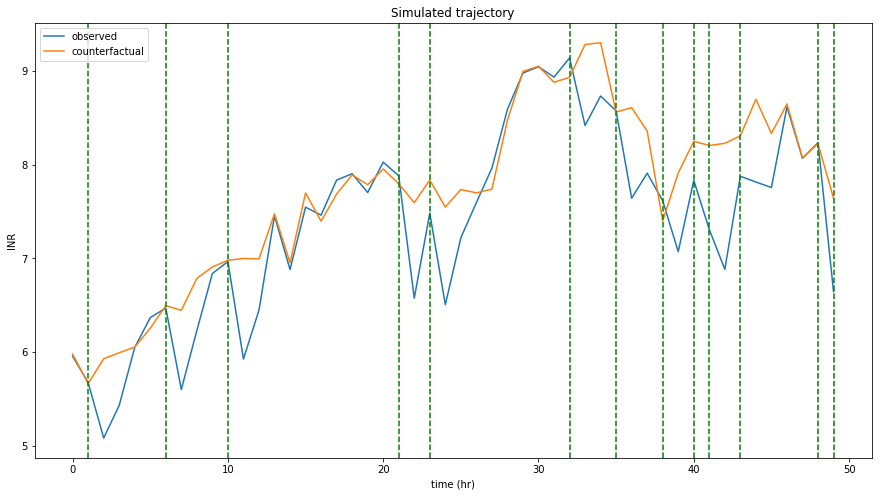

missing 0.0% of observations


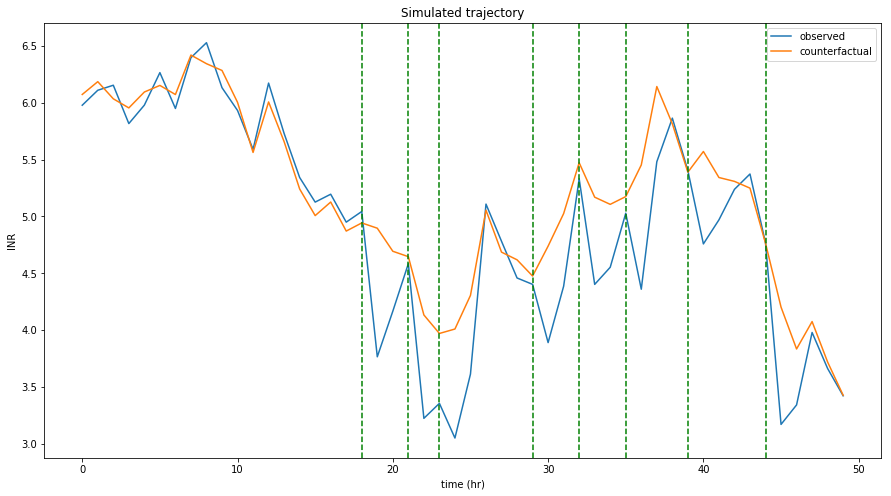

missing 0.0% of observations


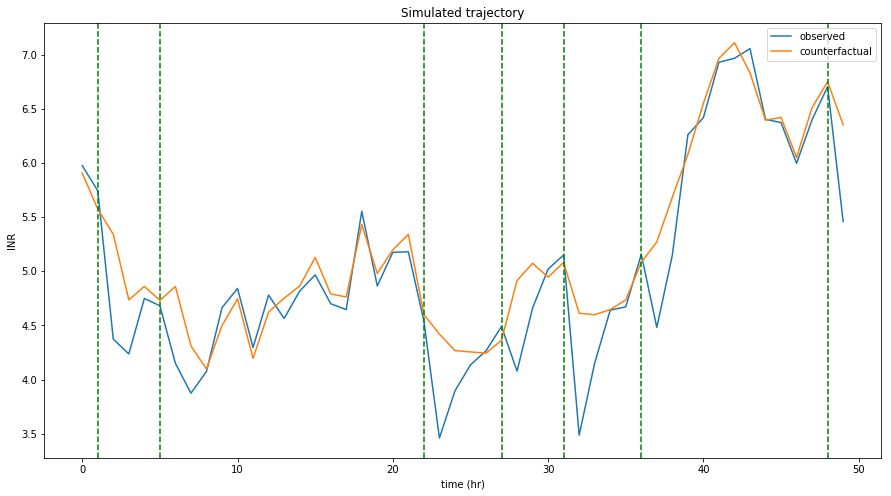

missing 0.0% of observations


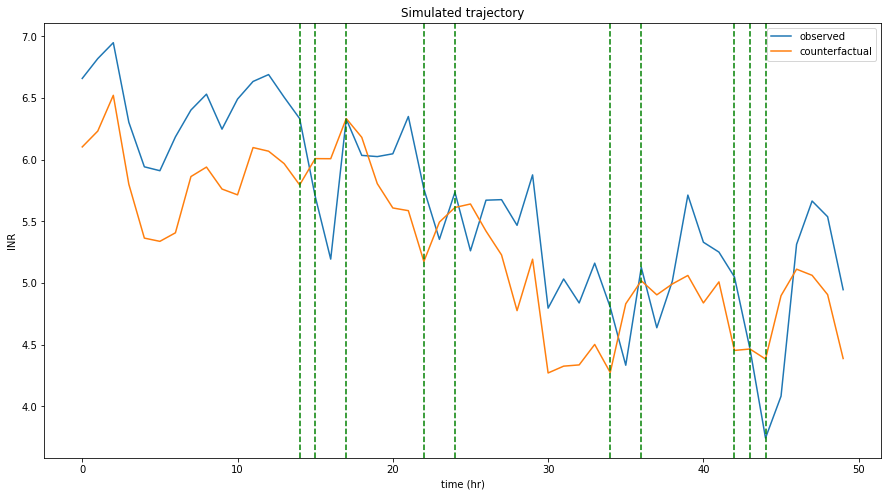

missing 0.0% of observations


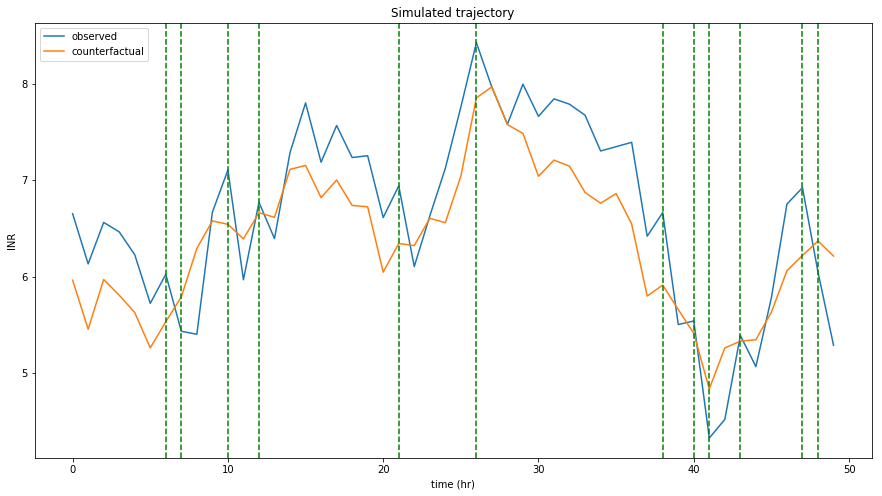

missing 0.0% of observations


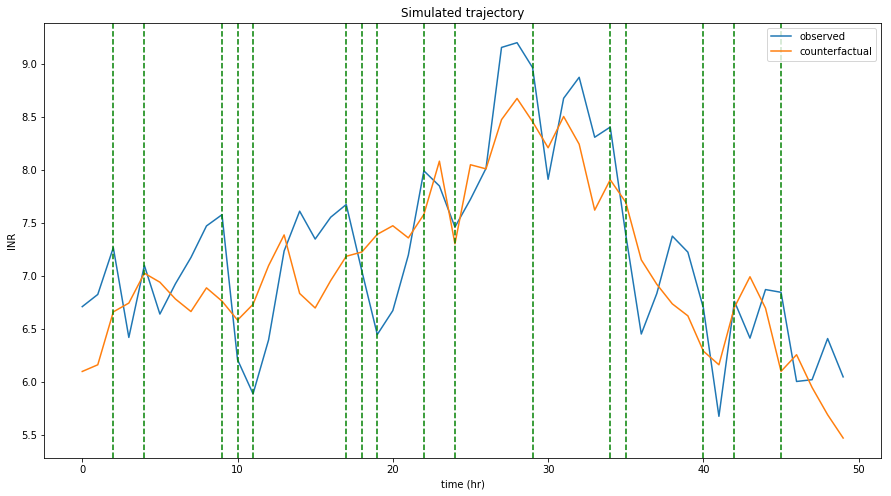

missing 0.0% of observations


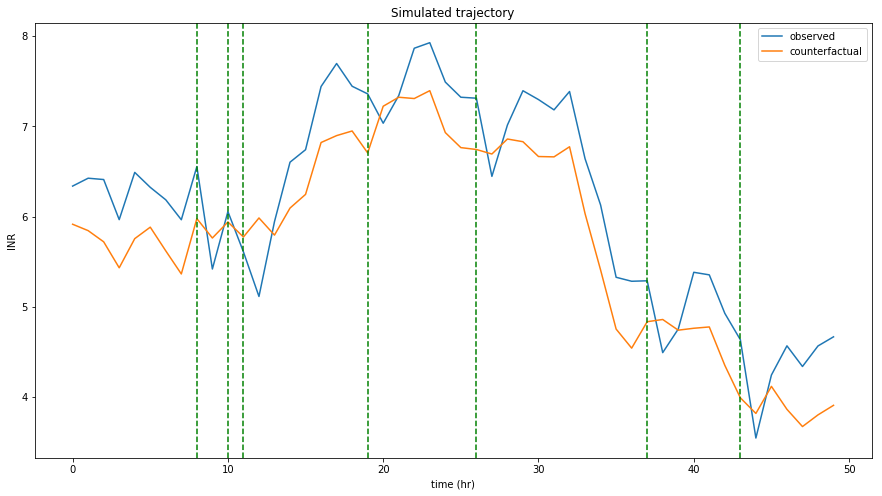

missing 0.0% of observations


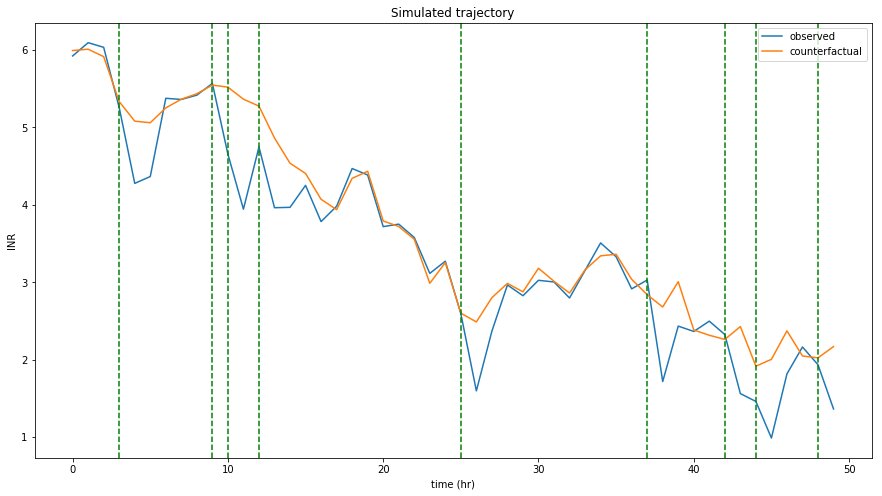

missing 0.0% of observations


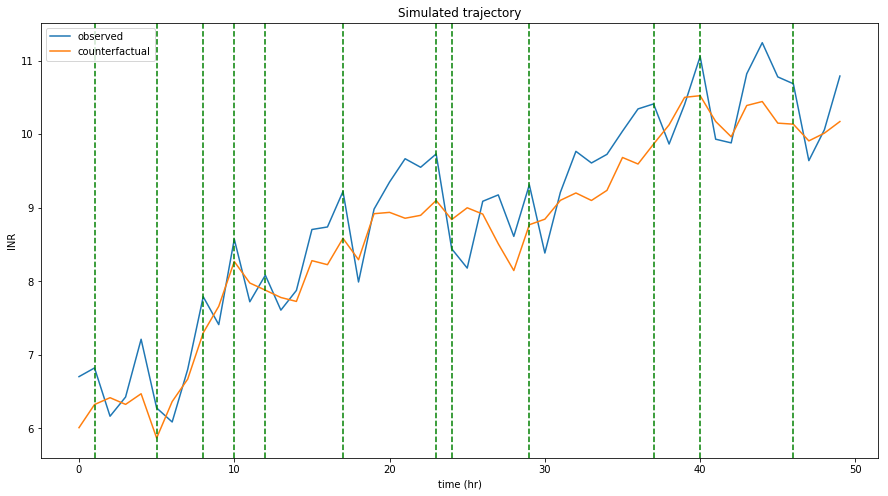

missing 0.0% of observations


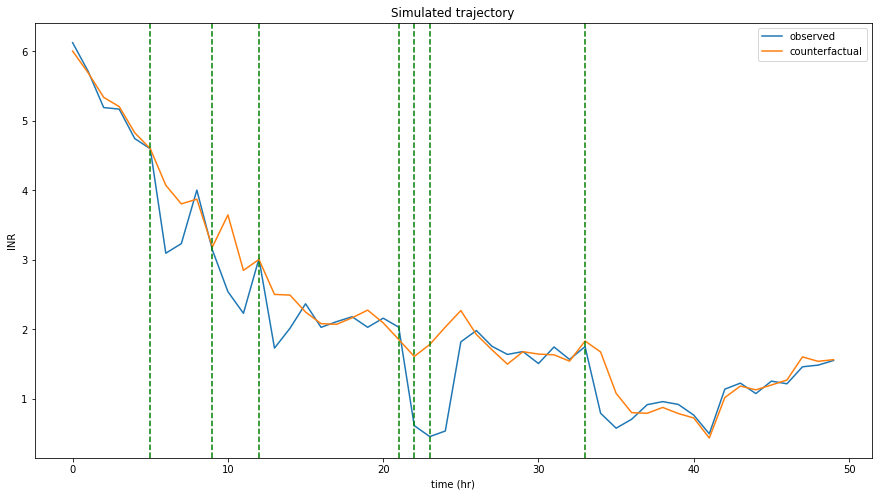

missing 0.0% of observations


In [131]:
model = Model(50, 10, 0.0)
model.run_simulation()

### EM

In [132]:
class EM:
    def __init__(self, y, X, c, J, K):
        # Store inputs
        self.num_patients = np.shape(y)[0] 
        self.T = np.shape(y)[1] # length of the observed sequence
        self.y = y
        self.X = X # treatment matrix
        self.c = c # chronic conditions
        self.K = K  # number of interaction terms modeled
        self.J = J # number of past treatment effects to be considered
        
        # Other model parameters
        self.N = np.shape(self.X)[2] # number of treatments
        self.M = np.shape(self.c)[1] # number of chronic conditions
        self.Q = np.zeros((self.num_patients, self.T, self.K)) # interaction term
        
        # Model Parameters to be estimated
        self.A = np.random.randn(self.J, self.N)*0.01 # coefficients a_j's
        self.b = np.random.randn(self.M)*0.01
        self.d = np.zeros(self.K)
        self.sigma_1 = .05
        self.sigma_2 = .005
        self.sigma_0 = .05 # initial state variance
        self.init_z = np.random.normal(6, self.sigma_0, size = 1)# np.random.uniform(0, 10, size = 1) # initial state mean
        
        # create coefficient matrix
        mtx = []
        for n in range(self.num_patients):
            columns = []
            for j in range(1, self.J+1):
                col = np.roll(self.X[n, :, :], shift=j, axis=0)
                col[[i for i in range(0, j)], :] = 0
                columns.append(col)
            C = np.stack([self.c[n, :] for i in range(self.T)], axis = 0)
            columns.append(C)
            coeff_mtx = np.concatenate(columns, axis = 1)
            nans = np.where(np.isnan(self.y[n, :]))[0]
            coeff_mtx = np.delete(coeff_mtx, nans, axis = 0)
            mtx.append(coeff_mtx)
        self.coeff_mtx = np.concatenate(mtx, axis = 0)
        self.params = np.zeros(self.N*self.J + self.M + self.K)
        
        # Intermediate values to stored
        self.mu_filter = np.zeros((self.num_patients, self.T)) # mu_t|t
        self.sigma_filter = np.zeros((self.num_patients, self.T)) # sigma^2_t|t
        self.kgain = np.zeros((self.num_patients, self.T)) # K_t, kalman gain
        self.jgain = np.zeros((self.num_patients, self.T)) # J_t, backward kalman gain 
        self.mu_smooth = np.zeros((self.num_patients, self.T)) # mu_t|T
        self.sigma_smooth = np.zeros((self.num_patients, self.T)) # sigma^2_t|T
        self.mu_square_smooth = np.zeros((self.num_patients, self.T)) # E[z_t^2|{y}]
        self.mu_ahead_smooth = np.zeros((self.num_patients, self.T)) # E[z_t * z_{t-1}|{y}]
        self.sigma_ahead_smooth = np.zeros((self.num_patients, self.T))
    
    # compute the added effect, denoted pi_t, at time t given the current parameter values 
    def added_effect(self, n, t):
        treatment_effect = 0
        for j in range(self.J):
            if t-1 >= j:
                treatment_effect = treatment_effect + np.dot(self.A[j, :], self.X[n, t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c[n, :]) # total added effect
        return pi
    
    '''E Step Calculations'''
    # kalman filter update step
    def kfilter(self, n, t):
        if np.isnan(self.y[n, t+1]):
            self.mu_filter[n, t+1] = self.mu_filter[n, t]
            self.sigma_filter[n, t+1] = self.sigma_filter[n, t] + self.sigma_1
        else:
            self.kgain[n, t+1] = (self.sigma_0 + t * self.sigma_1) / (self.sigma_0 + t * self.sigma_1 + self.sigma_2)
            mu_pred = self.mu_filter[n, t] 
            self.mu_filter[n, t+1] = mu_pred + self.kgain[n, t+1] * (self.y[n, t+1] - mu_pred - self.added_effect(n, t+1))
            sigma_pred = self.sigma_filter[n, t] + self.sigma_1
            self.sigma_filter[n, t+1] = (1 - self.kgain[n, t+1]) * sigma_pred
    
    # kalman filter for each time point, message passing forward
    def forward(self):
        for n in range(self.num_patients):
            self.mu_filter[n, 0] = self.init_z
            self.sigma_filter[n, 0] = self.sigma_0
            for t in range(self.T-1):
                self.kfilter(n, t)
    
    # kalman smoother update step
    def ksmoother(self, n, t):
        sigma_pred = self.sigma_filter[n, t] + self.sigma_1 # sigma^2_t+1|t
        self.jgain[n, t] = self.sigma_filter[n, t] / sigma_pred
        self.mu_smooth[n, t] = self.mu_filter[n, t] + self.jgain[n, t] * (self.mu_smooth[n, t+1] - self.mu_filter[n, t])
        self.sigma_smooth[n, t] = self.sigma_filter[n, t] + np.square(self.jgain[n, t]) * (self.sigma_smooth[n, t+1] - sigma_pred)
        self.mu_square_smooth[n, t] = self.sigma_smooth[n, t] + np.square(self.mu_smooth[n, t])
    
    def backward(self):
        for n in range(self.num_patients):
            self.mu_smooth[n, self.T-1] = self.mu_filter[n, self.T-1]
            self.sigma_smooth[n, self.T-1] = self.sigma_filter[n, self.T-1]
            self.mu_square_smooth[n, self.T-1] = self.sigma_smooth[n, self.T-1] + np.square(self.mu_smooth[n, self.T-1])
            for t in range(self.T-2, -1, -1):
                self.ksmoother(n, t)     
    
    # backward recursion to compute sigma^2_{t, t-1}|T, which is necessary to compute mu_ahead_smooth
    def backward_sigma_ahead(self, n, t):        
        if t == self.T-2:
            self.sigma_ahead_smooth[n, t] = (1 - self.kgain[n, t]) * self.sigma_smooth[n, t]
            return self.sigma_ahead_smooth[n, t]
        else:
            sigma_ahead = self.backward_sigma_ahead(n, t+1)
            self.sigma_ahead_smooth[n, t] = self.sigma_smooth[n, t] * self.jgain[n, t-1] + \
                self.jgain[n, t] * (sigma_ahead - self.sigma_smooth[n, t]) * self.jgain[n, t-1]
            return self.sigma_ahead_smooth[n, t]
    
    def calc_mu_ahead_smooth(self):
        for n in range(self.num_patients):
            for t in range(self.T-1):
                self.mu_ahead_smooth[n, t] = self.sigma_ahead_smooth[n, t] + self.mu_smooth[n, t] * self.mu_smooth[n, t+1]
    
    def E_step(self):
        self.forward()
        self.backward()
        for n in range(self.num_patients):
            self.backward_sigma_ahead(n, 0)
        self.calc_mu_ahead_smooth()
    
    '''M Step Calculations'''
    def sigma_0_mle(self):
        result = 0
        for n in range(self.num_patients):
            result += self.mu_square_smooth[n, 0] - np.square(self.mu_smooth[n, 0])
        result /= self.num_patients
        self.sigma_0 = result
        
    def sigma_1_mle(self):
        result = 0
        for n in range(self.num_patients):
            for t in range(self.T-1):
                result += self.mu_square_smooth[n, t+1]-2*self.mu_ahead_smooth[n, t]+self.mu_square_smooth[n, t]
        self.sigma_1 = (result / (self.T-1)) / self.num_patients
    
    def init_z_mle(self):
        result = 0
        for n in range(self.num_patients):
            result += self.mu_smooth[n, 0]
        result /= self.num_patients
        self.init_z = result
    
    def pi_mle(self):
        rhs_list = []
        for n in range(self.num_patients):
            rhs = np.subtract(self.y[n, :], self.mu_smooth[n, :])
            rhs = np.delete(rhs, np.where(np.isnan(rhs))[0])
            rhs_list.append(rhs)
        rhs_concat = np.concatenate(rhs_list, axis = 0)
        params = sp.linalg.lstsq(self.coeff_mtx, rhs_concat)[0] # params as a long vector
        self.A = np.reshape(params[0:self.N*self.J], (self.J, self.N))
        self.b = np.array(params[self.N*self.J:self.N*self.J+self.M])
        self.d = np.array(params[self.N*self.J+self.M:])
        self.params = params 
    
    def sigma_2_mle(self):
        result = 0
        for n in range(self.num_patients):
            num_sum = 0
            for t in range(self.T):
                if not np.isnan(self.y[n, t]):
                    result += np.square(self.y[n, t]-self.added_effect(n, t))-2*(self.y[n, t]-self.added_effect(n, t)) \
                        *self.mu_smooth[n, t] + self.mu_square_smooth[n, t]
                    num_sum += 1
            self.sigma_2 += result / num_sum
        self.sigma_2 /= self.num_patients
        
    def M_step(self):
        self.init_z_mle()
        self.sigma_0_mle()
        self.sigma_1_mle()
        self.pi_mle()
        self.sigma_2_mle()
    
    def set_params(self):
        self.sigma_1 = model.noise_1
        self.sigma_2 = model.noise_2
        
    '''Run EM for fixed iterations or until convergence'''
    def run_EM(self, max_num_iter, tol=.0001):
        #self.set_params()
        for i in range(max_num_iter):
            prev = self.params
            prev_sigma_1 = self.sigma_1
            prev_sigma_2 = self.sigma_2
            prev_init_z = self.init_z
            prev_sigma_0 = self.sigma_0
            self.E_step()
            self.M_step()
            diff = np.absolute(np.subtract(prev, self.params))
            if np.all(diff < tol) and abs(self.sigma_1 - prev_sigma_1) < tol and abs(self.sigma_2 - prev_sigma_2) < tol \
                and abs(self.init_z - prev_init_z) < tol and abs(self.sigma_0 - prev_sigma_0) < tol:
                print('{} iterations before convergence'.format(i+1))
                self.plot()
                return
        print('max iterations: {} reached'.format(max_num_iter))
        self.plot()
               
    def plot(self):
        for n in range(self.num_patients):
            times = list(range(self.T))
            fig = plt.figure()
            plt.plot(times, self.y[n, :], label = 'observed values')
            plt.plot(times, model.z[n, :], label = 'true values')
            plt.plot(times, self.mu_filter[n, :], label = 'filtered values')
            plt.plot(times, self.mu_smooth[n, :], label = 'smoothened values')
            plt.xlabel('time (hr)')
            plt.ylabel('INR')
            plt.title('Kalman Filter Results')
            plt.legend()
            fig.set_figheight(8)
            fig.set_figwidth(15)
            plt.show()

512 iterations before convergence


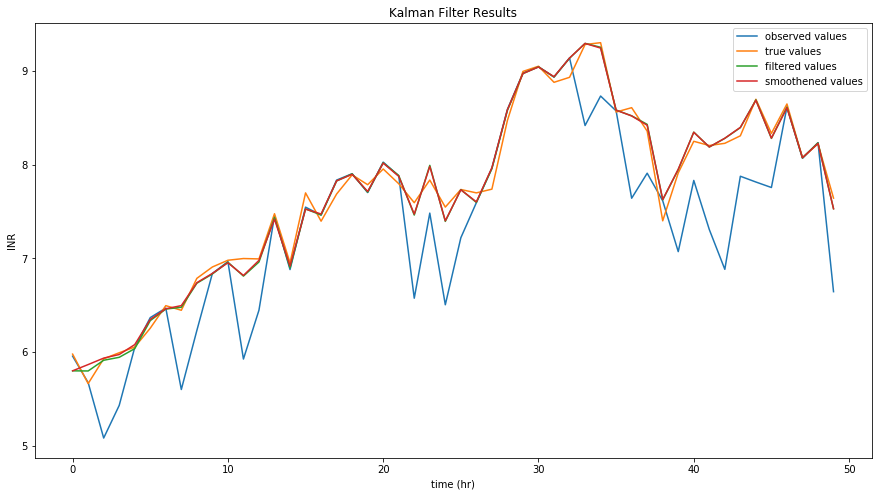

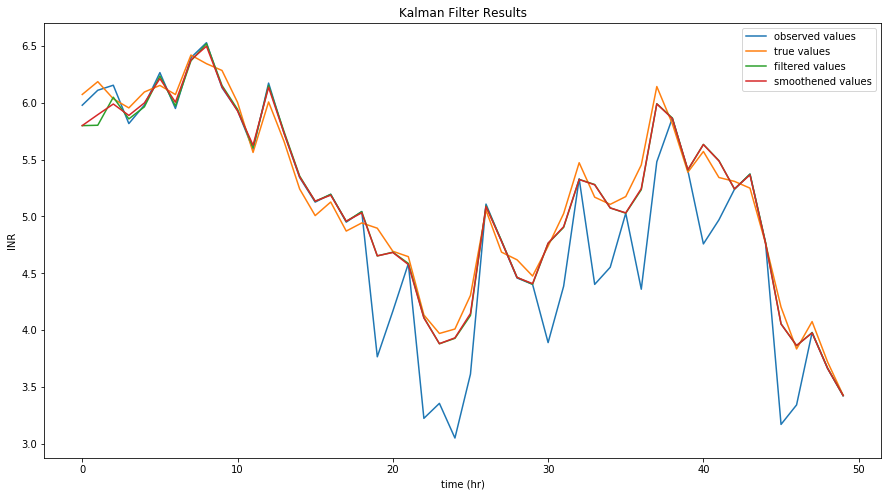

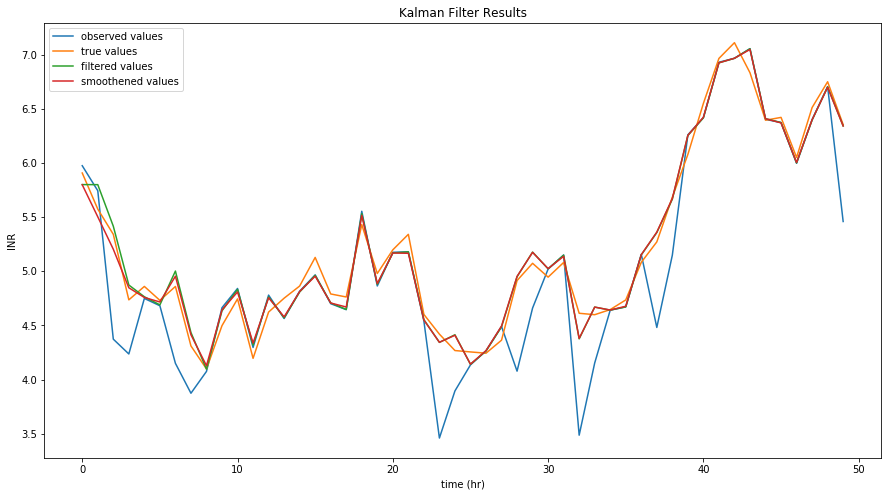

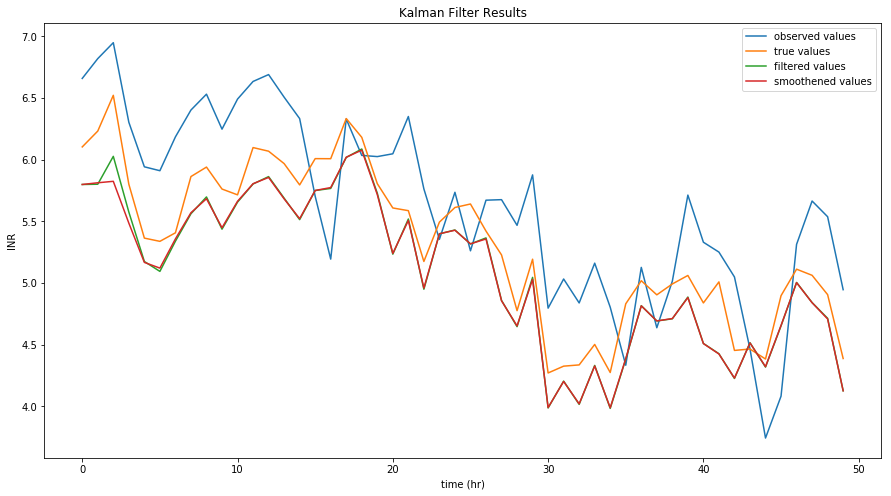

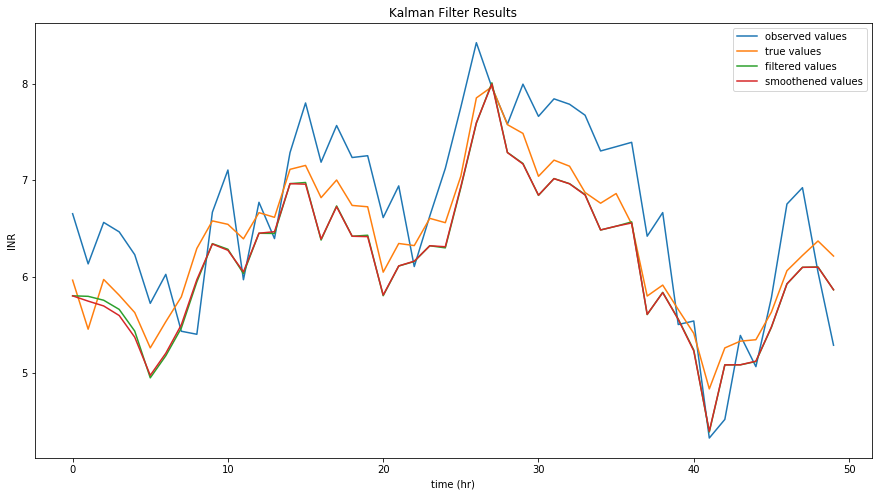

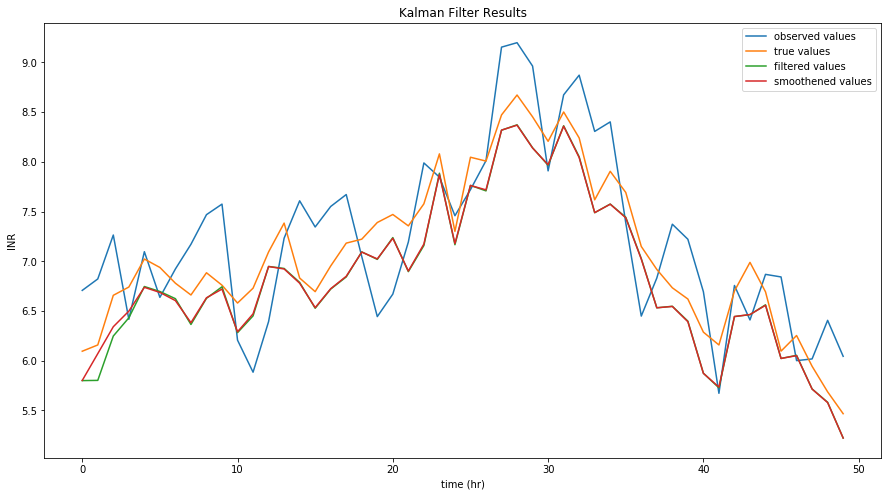

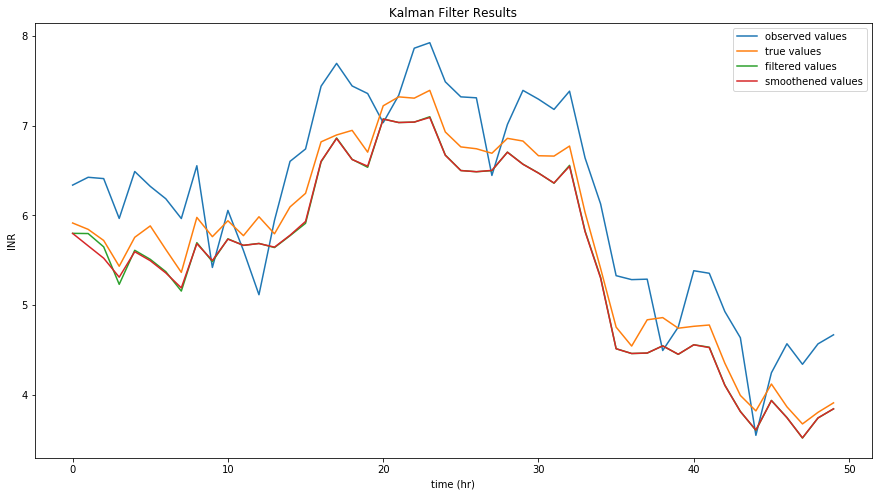

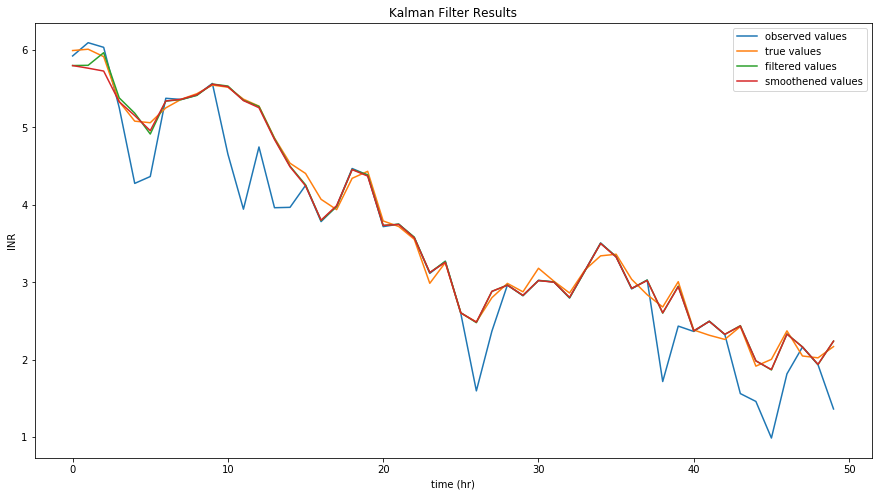

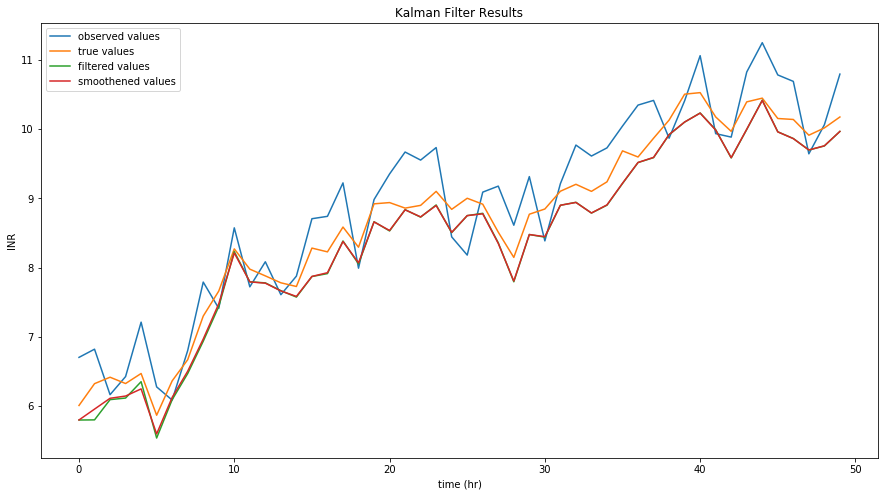

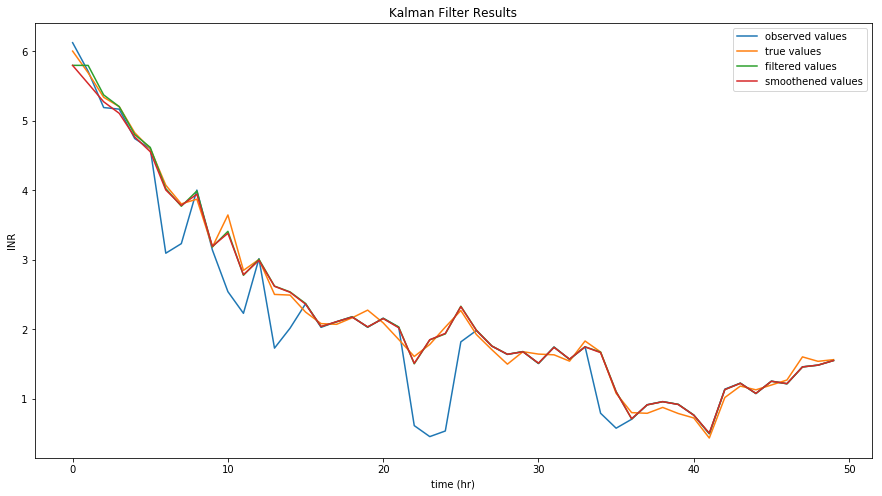

In [133]:
em = EM(model.y, model.X, model.c, model.A.shape[0], 0)
em.run_EM(2000)

In [134]:
print('estimated params: {}'.format(em.params))
print('true params: {}'.format([model.A, model.b]))
print('estimated initial state mean: {}'.format(em.init_z))
print('true initial state mean: {}'.format(model.init_z))
print('estimated sigma_0: {}'.format(em.sigma_0))
print('true sigma_0: {}'.format(model.noise_0))
print('estimated sigma_1: {}'.format(em.sigma_1))
print('true sigma_1: {}'.format(model.noise_1))
print('estimated sigma_2: {}'.format(em.sigma_2))
print('true sigma_2: {}'.format(model.noise_2))
print('estimated ratio: {}'.format(em.sigma_1/em.sigma_2))
print('true ratio: {}'.format(model.noise_1/model.noise_2))

estimated params: [-0.87877497 -0.52003191  0.82533643]
true params: [array([[-0.9],
       [-0.5]]), array([0.6])]
estimated initial state mean: 5.799524541462622
true initial state mean: 6
estimated sigma_0: 0.0005430905027949962
true sigma_0: 0.01
estimated sigma_1: 0.11496487579760128
true sigma_1: 0.1
estimated sigma_2: 0.04939156045385358
true sigma_2: 0.01
estimated ratio: 2.3276218597104803
true ratio: 10.0


### Last Observation Carry Forward

In [67]:
# assume the first observation is not nan and the data array is not entirely nan
def LBCF(data):
    filled = np.zeros(data.shape)
    for n in range(data.shape[0]):
        for i, y in enumerate(data[n, :]):
            if np.isnan(y):
                filled[n, i] = filled[n, i-1]
            else:
                filled[n, i] = y
    return filled

122 iterations before convergence


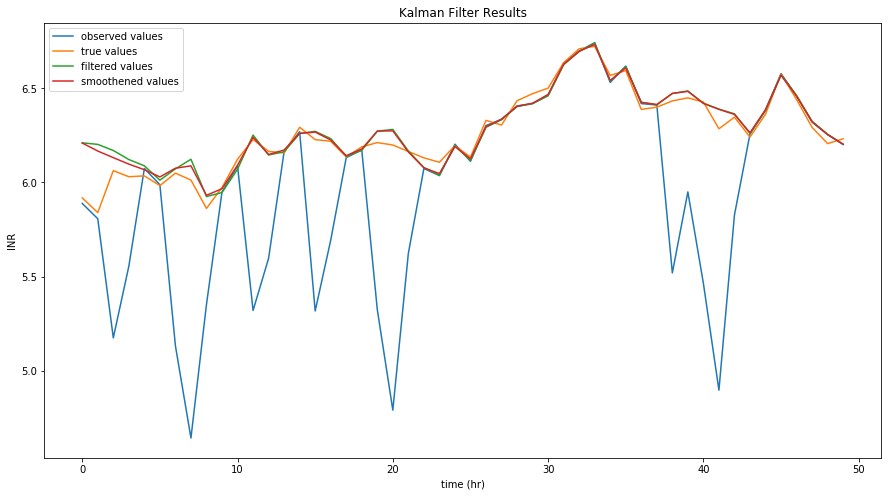

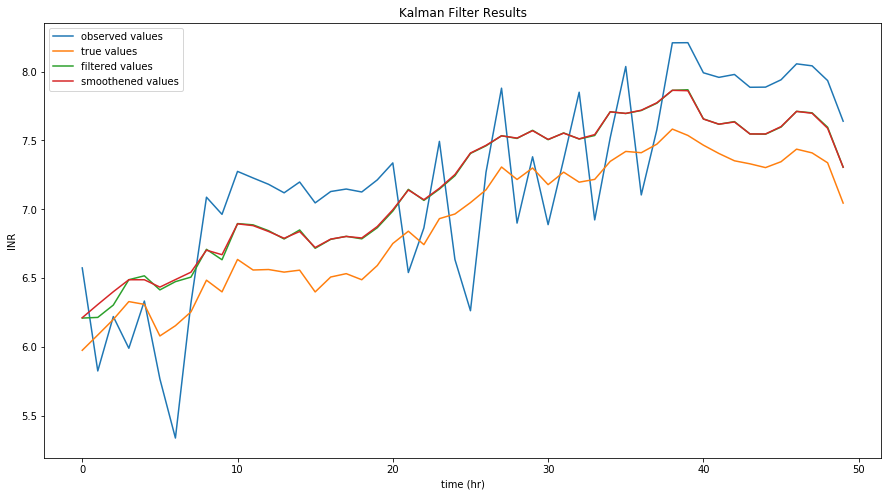

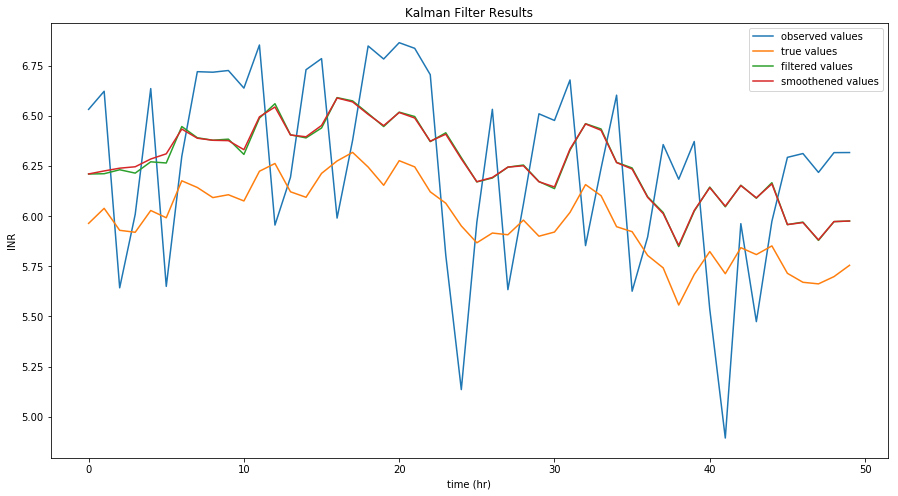

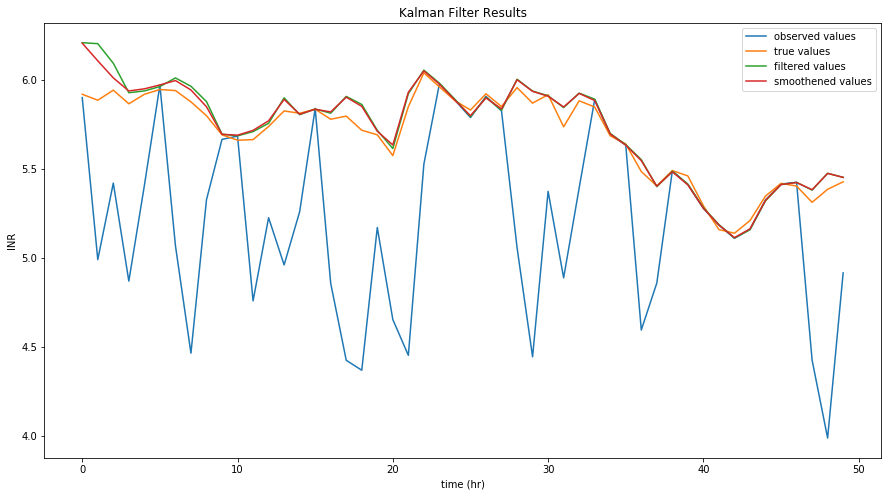

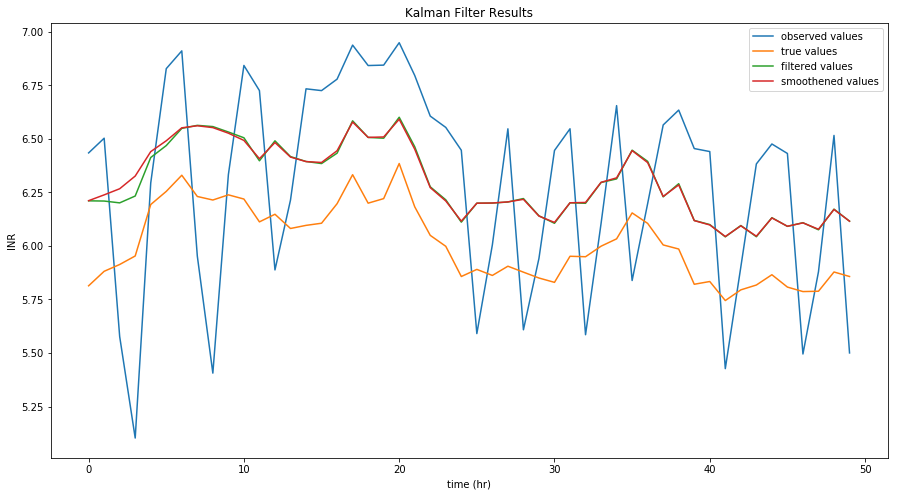

In [68]:
em_1 = EM(LBCF(model.y), model.X, model.c, model.A.shape[0], 0)
em_1.run_EM(1000)

In [56]:
print('estimated params: {}'.format(em_1.params))
print('true params: {}'.format([model.A, model.b]))
print('estimated sigma_1: {}'.format(em_1.sigma_1))
print('true sigma_1: {}'.format(model.noise_1))
print('estimated sigma_2: {}'.format(em_1.sigma_2))
print('true sigma_2: {}'.format(model.noise_2))
print('estimated ratio: {}'.format(em_1.sigma_1/em_1.sigma_2))
print('true ratio: {}'.format(model.noise_1/model.noise_2))

estimated params: [-1.64175057e+79 -1.27626194e+79 -3.81070219e+79]
true params: [array([[-0.9],
       [-0.5]]), array([0.6])]
estimated sigma_1: 1.0575835817372185e+158
true sigma_1: 0.1
estimated sigma_2: 2.240919673593271e+159
true sigma_2: 0.01
estimated ratio: 0.04719417631071996
true ratio: 10.0


### Notes on the current model

1. Identifying coefficients is still somewhat challenging (often off by a little)
2. When the coefficients are too small i.e. closer to the noise value, the model is unable to recover them.
3. The model has trouble identifying the noise values
4. The shift between the smoothened values and the true value is the difference between the estimated coefficient b and the true value of the coefficient. If the model underestimates, since y is the same for both underlying data generaing model and the estimating model, the estimated z would be larger than the true state value.  